## Import modules and dataset

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import probplot
from scipy.stats import zscore

In [3]:
df = pd.read_csv("water_dataX.csv",encoding='ISO-8859-1') 
df.head() 

,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203,NAN,0.1,11,27,2014
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189,2,0.2,4953,8391,2014
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179,1.7,0.1,3243,5330,2014
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64,3.8,0.5,5382,8443,2014
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83,1.9,0.4,3428,5500,2014


In [4]:
df.shape

(1991, 12)

Checking for data types and manipulating the types as per necessity

In [5]:
df.dtypes

STATION CODE                        object
LOCATIONS                           object
STATE                               object
Temp                                object
D.O. (mg/l)                         object
PH                                  object
CONDUCTIVITY (µmhos/cm)             object
B.O.D. (mg/l)                       object
NITRATENAN N+ NITRITENANN (mg/l)    object
FECAL COLIFORM (MPN/100ml)          object
TOTAL COLIFORM (MPN/100ml)Mean      object
year                                 int64
dtype: object

# Data preprocessing

### Change the column names for easy accessing

In [6]:
df = df.rename(columns={"D.O. (mg/l)": "DO",
                        "CONDUCTIVITY (µmhos/cm)": "Conductivity",
                        "B.O.D. (mg/l)": "BOD",
                        "NITRATENAN N+ NITRITENANN (mg/l)": "NI",
                        "FECAL COLIFORM (MPN/100ml)": "Fec_col",
                        "TOTAL COLIFORM (MPN/100ml)Mean": "Tot_col"})

In [7]:
df.head()

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203,NAN,0.1,11,27,2014
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189,2,0.2,4953,8391,2014
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179,1.7,0.1,3243,5330,2014
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64,3.8,0.5,5382,8443,2014
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83,1.9,0.4,3428,5500,2014


### Converting the object columns from "temp" to "year" into numeric values:

In [8]:
def convert_to_numeric(df):
    num_col = df.shape[1] # stores the number of columns
    # Start from index 3 - "temperature" column
    for index in range(3, num_col):
        col_name = df.iloc[:, index].name
        df[col_name] = pd.to_numeric(df[col_name], errors="coerce")
    return df

df = convert_to_numeric(df)
df.dtypes

STATION CODE     object
LOCATIONS        object
STATE            object
Temp            float64
DO              float64
PH              float64
Conductivity    float64
BOD             float64
NI              float64
Fec_col         float64
Tot_col         float64
year              int64
dtype: object

In [9]:
# replacing all string "NAN" values with numeric nan values using numpy
def convert_to_nan(df):
    n_col = df.shape[1]
    for index in range(n_col):
        df.iloc[:, index]  = df.iloc[:, index].replace("NAN", np.nan)
    return df

df = convert_to_nan(df)

### Checking for null values and replacing them with median values

In [10]:
# checking for null values

df.isnull().sum().sort_values()

year              0
PH                8
Conductivity     25
DO               31
BOD              43
Temp             92
STATION CODE    122
Tot_col         132
LOCATIONS       184
NI              225
Fec_col         316
STATE           761
dtype: int64

In [11]:
# replacing all null values with median values

df_num = df.select_dtypes(exclude="object")
df_num_col = df_num.columns
imputer = SimpleImputer(strategy="median")

df_num = imputer.fit_transform(df_num)
df_num = pd.DataFrame(df_num, columns=df_num_col)

### Filling the categorically missing values

In [12]:
df_cat = df.select_dtypes(include="object")
df_cat.isnull().sum() 

STATION CODE    122
LOCATIONS       184
STATE           761
dtype: int64

In [13]:
df[df["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU,29.0,6.600,7.200,1300.0,2.700,0.200,21.000,60.0,2014
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU,29.0,7.300,7.100,607.0,3.600,0.880,33.000,104.0,2013
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU,29.0,7.400,7.000,3101.0,15.600,0.150,76.000,174.0,2012
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,NaN,28.4,6.900,7.200,385.0,2.300,0.130,108.000,196.0,2010
1351,1330,NaN,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",29.0,7.500,7.200,473.0,2.100,0.100,220.000,338.0,2009
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN,28.0,7.200,7.200,439.0,2.280,0.140,236.000,415.0,2008
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN,31.0,7.600,7.100,428.0,2.500,0.150,226.000,443.0,2007
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN,NaN,4.325,7.045,547.0,2.075,0.250,25.000,109.0,2006
1986,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN,NaN,7.900,738.000,7.2,2.700,0.518,0.518,202.0,2003


In [14]:
# Station Code with value 1330 will have Location - TAMBIRAPARANI which belongs in STATE - TAMIL NADU
# Hence, replacing all the NAN occurences in STATE with TAMILNADU

pd.set_option('mode.chained_assignment', None)
df_cat_copy = df_cat.copy()

df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]
df_cat_copy["STATE"][df_cat_copy["STATION CODE"] == "1330"] = df_cat_copy["STATE"][df_cat_copy["STATION CODE"] == "1330"].fillna("TAMILNADU")

df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,NaN,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1986,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [15]:
# The NULL values in LOCATION attribute are in STATE attribute (ex - above dataframe)
# So, fill the NULL values in LOCATION attribute with the corresponding STATE value
# And, the state value will be replaced by the function "fill_state" defined below this cell


def fill_locations(df_cat):
    location_null = df_cat[df_cat["LOCATIONS"].isnull()] 
    location_null_indices = location_null.index 
    for index in location_null_indices: 
        state_value = location_null["STATE"][index]
        location_null["LOCATIONS"][index] = state_value
        location_null["STATE"][index] = np.nan
    df_cat[df_cat["LOCATIONS"].isnull()] = location_null
    return

fill_locations(df_cat_copy)
df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1986,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [16]:
df_cat_copy[df_cat_copy["LOCATIONS"] == "TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,NaN,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1986,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [17]:
# filling the missing station code 

def fill_code(df_cat): 
    station_null = df_cat[df_cat["STATION CODE"].isnull()] 
    station_null_indices = station_null.index 
    for index in station_null_indices:
        stat_code = np.nan
        location_index = station_null["LOCATIONS"][index]
        code_at_location = df_cat["STATION CODE"][df_cat["LOCATIONS"] == location_index]
        for index_code in code_at_location.index:
            if (code_at_location[index_code] != np.nan):
                stat_code = code_at_location[index_code]
                break
        station_null["STATION CODE"][index] = stat_code
    df_cat[df_cat["STATION CODE"].isnull()] = station_null
    return

fill_code(df_cat_copy)
df_cat_copy[df_cat_copy["LOCATIONS"] == "TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN
1986,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [18]:
# Filling all state NAN values which have corresponding station code value
def fill_state(df_cat):
    station_code = df_cat["STATION CODE"].unique()
    for index in range(station_code.shape[0]):
        if (station_code[index] != np.nan):
            df_state = df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]] 
            state_values = df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]]
            state = np.nan
            for index_state in range(state_values.shape[0]):
                if (state_values.iloc[index_state] != np.nan):
                    state = state_values.iloc[index_state]
                    break
            df_state_fill = df_state.fillna(state) 
            df_cat["STATE"][df_cat["STATION CODE"] == station_code[index]] = df_state_fill
    return
fill_state(df_cat_copy)
df_cat_copy[df_cat_copy["STATION CODE"] == "1330"]

,STATION CODE,LOCATIONS,STATE
166,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
424,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
677,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1168,1330,TAMBIRAPARANI AT ARUMUGANERI,TAMILNADU
1351,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1513,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1626,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1745,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1896,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU
1986,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU


In [19]:
# null values which comes under not satisfying any of these

df_cat_copy.isnull().sum()

STATION CODE     5
LOCATIONS        3
STATE           13
dtype: int64

In [20]:
# The first location KABBANI AT MUTHANKARA is in STATE Kerela
df_cat_copy["STATE"][1106] = "KERALA"
df_cat_copy["STATE"][1107] = "KERALA"
df_cat_copy["STATE"][1650] = "CHANDIGARH"
df_cat_copy["STATE"][1651] = "CHANDIGARH"
df_cat_copy["STATE"][1652] = "CHANDIGARH"
df_cat_copy["STATE"][1770] = "CHANDIGARH"
df_cat_copy["STATE"][1771] = "CHANDIGARH"
df_cat_copy["STATE"][1772] = "CHANDIGARH"
df_cat_copy["STATE"][1784] = "DAMAN & DIU"
df_cat_copy["STATE"][1785] = "DAMAN & DIU"
df_cat_copy["STATION CODE"][1784] = "0000" # I am setting this according to myself
df_cat_copy["STATION CODE"][1785] = "0000"

In [21]:
df_cat = df_cat_copy
df_final = pd.concat([df_cat, df_num], axis=1)
df_final.isnull().sum()

STATION CODE    3
LOCATIONS       3
STATE           3
Temp            0
DO              0
PH              0
Conductivity    0
BOD             0
NI              0
Fec_col         0
Tot_col         0
year            0
dtype: int64

### Final missing values count after all preprocessing

In [22]:
df_null = df_final[(df_final["STATION CODE"].isnull()) & (df_final["LOCATIONS"].isnull()) & (df_final["STATE"].isnull())]
df_null_indices = df_null.index
df_final.drop(df_null_indices, axis=0, inplace=True)
df_final.isnull().sum()

STATION CODE    0
LOCATIONS       0
STATE           0
Temp            0
DO              0
PH              0
Conductivity    0
BOD             0
NI              0
Fec_col         0
Tot_col         0
year            0
dtype: int64

In [23]:
df_final.shape

(1988, 12)

### Plotting

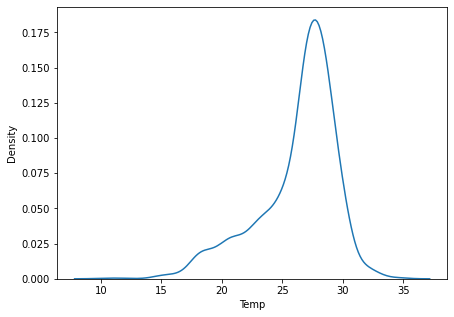

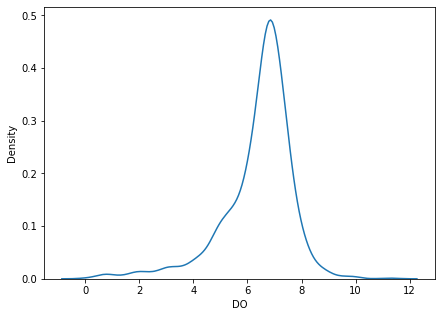

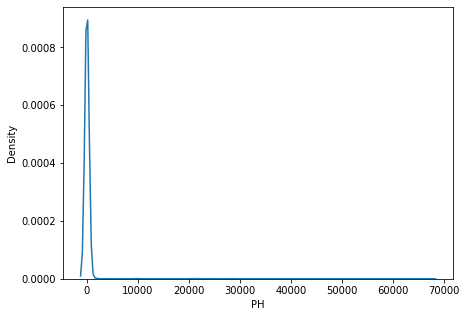

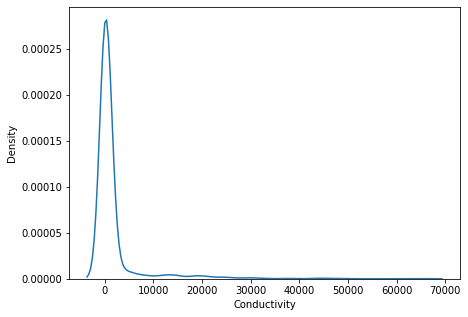

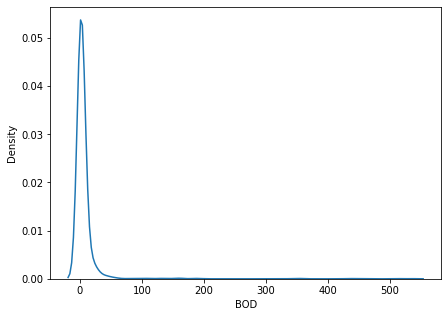

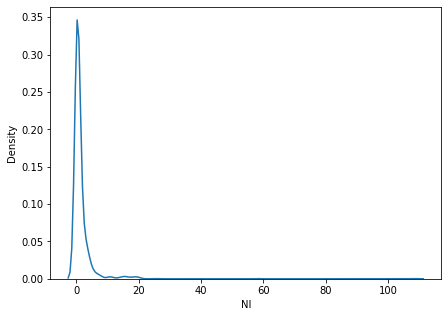

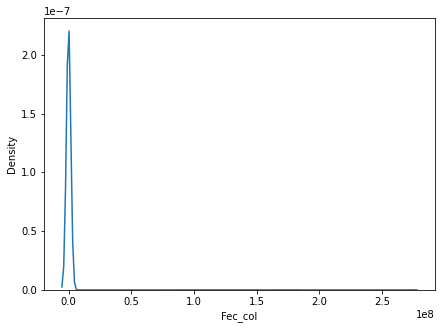

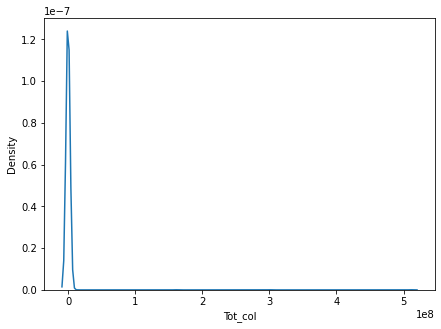

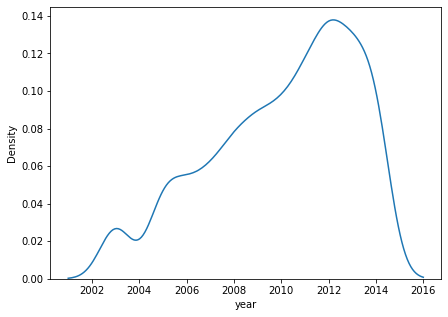

In [24]:
df_num_final = df_final.select_dtypes(exclude="object")

def plot_kde(df):
    n_col = df.shape[1]
    for index in range(n_col):
        col_index = df.iloc[:, index]
        fig, ax = plt.subplots(1,1, figsize=(7, 5))
        sns.kdeplot(data=df, x=col_index.name)
        
plot_kde(df_num_final)

In [25]:
df

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203.0,NaN,0.100,11.000,27.0,2014
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189.0,2.0,0.200,4953.000,8391.0,2014
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179.0,1.7,0.100,3243.000,5330.0,2014
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64.0,3.8,0.500,5382.000,8443.0,2014
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83.0,1.9,0.400,3428.000,5500.0,2014
...,...,...,...,...,...,...,...,...,...,...,...,...
1986,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",NaN,NaN,7.9,738.0,7.2,2.7,0.518,0.518,202.0,2003
1987,1450,"PALAR AT VANIYAMBADI WATER SUPPLY HEAD WORK, T...",NaN,29.0,7.5,585.0,6.3,2.6,0.155,0.155,315.0,2003
1988,1403,"GUMTI AT U/S SOUTH TRIPURA,TRIPURA",NaN,28.0,7.6,98.0,6.2,1.2,NaN,NaN,570.0,2003
1989,1404,"GUMTI AT D/S SOUTH TRIPURA, TRIPURA",NaN,28.0,7.7,91.0,6.5,1.3,NaN,NaN,562.0,2003


In [26]:
# Here, almost all kde plots are Gaussian Like 
# Using Z-Score Normalization to detect outliers

df_num_final_norm = zscore(df_num_final, axis=0)


def indices_of_greater_than_3(df_norm):
    indices_arr = []
    n_col = df_norm.shape[1]
    for index in range(n_col):
        col_index = df_norm.iloc[: ,index]
        greater_than_3 = df_norm[col_index > 3]
        greater_than_3_index = greater_than_3.index
        indices_arr.extend(greater_than_3_index)
    return indices_arr

indices_arr = indices_of_greater_than_3(df_num_final_norm)
print("Number of outliers using Z-Score method-",len(indices_arr))
# df_final.iloc[indices_arr, :].head()


Number of outliers using Z-Score method- 139


In [27]:
# dropping these outliers
df_final.drop(indices_arr, axis=0, inplace=True)
df_final.shape

(1862, 12)

### Computing WQI

In [28]:
# Calculating Water Quality Index of each sample
df_num_final = df_final.select_dtypes(exclude="object")

# Dropping year and Temp attribute because they are not used for computing WQI
df_num_final.drop(["year", "Temp"], axis=1, inplace=True)

# Weight Vector(wi)
wi = np.array([0.2213, 0.2604, 0.0022, 0.4426, 0.0492, 0.0221, 0.0022])

# Standard values of parameters(si)
si = np.array([10, 8.5, 1000, 5, 45, 100, 1000])

# Ideal values of paramters(vIdeal)
vIdeal = np.array([14.6, 7, 0, 0, 0, 0, 0])

def calc_wqi(sample): 
    wqi_sample = 0
    num_col = 7
    for index in range(num_col):
        v_index = sample[index] # Obeserved value of sample at index
        v_index_ideal = vIdeal[index] # Ideal value of obeserved value
        w_index = wi[index] # weight of corresponding parameter of obeserved value
        std_index = si[index] # Standard value recommended for obeserved value
        q_index = (v_index - v_index_ideal) / (std_index - v_index_ideal)
        q_index = q_index * 100 # Final qi value of obeserved value
        wqi_sample += q_index*w_index
    return wqi_sample

In [29]:
# Computing WQI for the whole dataset
def calc_wqi_for_df(df):
    wqi_arr = []
    for index in range(df.shape[0]):
        index_row = df.iloc[index, :]
        wqi_row = calc_wqi(index_row)
        wqi_arr.append(wqi_row)
    return wqi_arr

In [30]:
wqi_arr = calc_wqi_for_df(df_num_final)
# Converting oridnary array to numpy array
wqi_arr = np.array(wqi_arr)
wqi_arr = np.reshape(wqi_arr, (-1, 1))

# Resetting index values of the dataframes
wqi_arr_df = pd.DataFrame(wqi_arr, columns=["WQI"]).reset_index()
df_final = df_final.reset_index()

In [31]:
# Combining dataframe of WQI and dataframe of attributes 
df_wqi = pd.concat([df_final, pd.DataFrame(wqi_arr, columns=["WQI"])], axis=1)
df_wqi.drop("index", axis=1, inplace=True)
df_wqi.shape

(1862, 13)

In [32]:
# These are samples with negative WQI
df_wqi[(df_wqi["WQI"] < 0)]

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year,WQI
196,3375,LUKHA RIVER AT MYNDIHATI (TRIBUTARY OF LUNAR),MEGHALAYA,20.5,6.7,2.7,1350.0,3.3000,1.100,7.0,16.0,2014.0,-6.855044
231,2,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,27.0,6.7,0.0,208.0,1.8965,0.516,221.0,468.0,2013.0,-61.637076
234,1865,RIVER DHADAR AT KOTHADA,GUJARAT,27.0,6.7,0.0,506.0,1.8965,6.000,26.0,227.0,2013.0,-65.334452
445,3375,LUKHA RIVER,MEGHALAYA,21.3,6.8,2.7,1074.0,3.2000,2.330,4.0,11.0,2013.0,-8.214971
718,3375,LUKHA RIVER AT MYNDIHATI (TRIBUTARY OF LUNAR),MEGHALAYA,25.0,6.9,2.6,1072.0,3.2000,1.170,3.0,21.0,2012.0,-10.579224


In [33]:
# Removing the samples with negative WQI
df_neg_indices = df_wqi[(df_wqi["WQI"] < 0)].index
df_wqi.drop(df_neg_indices, axis=0, inplace=True)

In [34]:
df_wqi

,STATION CODE,LOCATIONS,STATE,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year,WQI
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203.0,1.8965,0.100,11.000,27.0,2014.0,63.778321
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189.0,2.0000,0.200,4953.000,8391.0,2014.0,175.363506
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179.0,1.7000,0.100,3243.000,5330.0,2014.0,126.135831
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64.0,3.8000,0.500,5382.000,8443.0,2014.0,195.105659
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83.0,1.9000,0.400,3428.000,5500.0,2014.0,141.393246
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1857,1330,"TAMBIRAPARANI AT ARUMUGANERI, TAMILNADU",TAMILNADU,27.0,7.9,738.0,7.2,2.7000,0.518,0.518,202.0,2003.0,12746.407333
1858,1450,"PALAR AT VANIYAMBADI WATER SUPPLY HEAD WORK, T...",TAMILNADU,29.0,7.5,585.0,6.3,2.6000,0.155,0.155,315.0,2003.0,10091.343432
1859,1403,"GUMTI AT U/S SOUTH TRIPURA,TRIPURA",TRIPURA,28.0,7.6,98.0,6.2,1.2000,0.516,221.000,570.0,2003.0,1629.125767
1860,1404,"GUMTI AT D/S SOUTH TRIPURA, TRIPURA",TRIPURA,28.0,7.7,91.0,6.5,1.3000,0.516,221.000,562.0,2003.0,1508.008186


## WQI Prediction Analysis


      WQI Range           -         Classification

     Less than 25         -          Excellent(4)
        26–50             -             Good(3)
        51-75             -           Moderate(2)
       76-100             -              Poor(1)
    Greater than 100      -           Very Poor(0)

In [35]:
df_wqi["WQI clf"] = df_wqi["WQI"].apply(lambda x: (4 if (x <= 25) 
                                        else(3 if (26<=x<=50) 
                                        else(2 if (51<=x<=75) 
                                        else(1 if (76<=x<=100) 
                                        else 0))))) 

In [36]:
df_wqi.describe()

,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col,year,WQI,WQI clf
count,1857.000000,1857.00000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000,1857.000000
mean,26.249024,6.46968,21.444437,914.469160,3.904589,1.088036,2163.068225,6992.528810,2010.059774,374.095071,1.406031
std,3.235525,1.24775,125.862427,2557.465581,7.002613,1.576473,8095.718660,39406.757235,3.044247,2189.980440,1.057061
min,10.000000,0.00000,2.900000,3.700000,0.100000,0.000000,0.000000,0.000000,2003.000000,16.795814,0.000000
25%,25.000000,6.00000,6.900000,76.000000,1.100000,0.270000,38.000000,113.000000,2008.000000,55.271272,0.000000
50%,27.000000,6.70000,7.300000,169.000000,1.800000,0.516000,221.000000,468.000000,2011.000000,71.845041,2.000000
75%,28.200000,7.20000,7.700000,439.000000,3.400000,1.010000,590.000000,1630.000000,2013.000000,101.752648,2.000000
max,35.000000,10.00000,3384.000000,18291.000000,88.000000,12.150000,150250.000000,967500.000000,2014.000000,58680.748613,4.000000


In [37]:
features = list(df_wqi.columns)[3:11] 
data_f = df_wqi[features] 
data_f 

,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col
0,30.6,6.7,7.5,203.0,1.8965,0.100,11.000,27.0
1,29.8,5.7,7.2,189.0,2.0000,0.200,4953.000,8391.0
2,29.5,6.3,6.9,179.0,1.7000,0.100,3243.000,5330.0
3,29.7,5.8,6.9,64.0,3.8000,0.500,5382.000,8443.0
4,29.5,5.8,7.3,83.0,1.9000,0.400,3428.000,5500.0
...,...,...,...,...,...,...,...,...
1857,27.0,7.9,738.0,7.2,2.7000,0.518,0.518,202.0
1858,29.0,7.5,585.0,6.3,2.6000,0.155,0.155,315.0
1859,28.0,7.6,98.0,6.2,1.2000,0.516,221.000,570.0
1860,28.0,7.7,91.0,6.5,1.3000,0.516,221.000,562.0


In [38]:
features = list(df_wqi.columns)[:]
data_cluster = df_wqi['WQI clf']
data_cluster

0       2
1       0
2       0
3       0
4       0
       ..
1857    0
1858    0
1859    0
1860    0
1861    0
Name: WQI clf, Length: 1857, dtype: int64

In [39]:
data_f.head() 

,Temp,DO,PH,Conductivity,BOD,NI,Fec_col,Tot_col
0,30.6,6.7,7.5,203.0,1.8965,0.1,11.0,27.0
1,29.8,5.7,7.2,189.0,2.0000,0.2,4953.0,8391.0
2,29.5,6.3,6.9,179.0,1.7000,0.1,3243.0,5330.0
3,29.7,5.8,6.9,64.0,3.8000,0.5,5382.0,8443.0
4,29.5,5.8,7.3,83.0,1.9000,0.4,3428.0,5500.0
